# New well location

We work at GiantOil and collected data on oil samples from three regions. Parameters of each oil well
in the region are already known. We want to build a model that will help us to pick the region
with the highest profit margin.

**Project Steps** <a class="anchor" id="table_of_contents"></a>  
- [1. Data file and general info](#chapter1)  
   -  [1.1 Load dataset](#chapter1.1)  
   -  [1.2 Missing values](#chapter1.2)  
   -  [1.3 Exploratory Data Analysis](#chapter1.3)  
- [2. Model training and validating for each region](#chapter2)   
- [3. Profit calculation and risk evaluation](#chapter3)  
- [4. General conclusions](#chapter4)

## Data file and general info
***
<a class="anchor" id="chapter1"></a>

In [1]:
!pip install -U scikit-learn --upgrade

Defaulting to user installation because normal site-packages is not writeable
Requirement already up-to-date: scikit-learn in /home/jovyan/.local/lib/python3.7/site-packages (1.0)


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import scipy.stats as st
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

#ignore warnings
import sys
import warnings
if not sys.warnoptions:
       warnings.simplefilter("ignore")

### Load datasets
<a class="anchor" id="chapter1.1"></a>

In [3]:
df0 = pd.read_csv('/datasets/geo_data_0.csv')
df1 = pd.read_csv('/datasets/geo_data_1.csv')
df2 = pd.read_csv('/datasets/geo_data_2.csv')

In [4]:
#list of dataframes for easy iteration
df_list = [df0,df1,df2]

In [5]:
#show the first 5 rows for each dataframe
for df in df_list:
    display(df.head())

,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647


,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305


,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746


**Features**  
`id` — unique oil well identifier   
`f0`,`f1`,`f2` — three features of points

**Target**  
`product` — volume of reserves in the oil well (thousand barrels)

### Missing values and duplicates
<a class="anchor" id="chapter1.2"></a>

In [6]:
for df in df_list:
    #show general information
    display(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
id         100000 non-null object
f0         100000 non-null float64
f1         100000 non-null float64
f2         100000 non-null float64
product    100000 non-null float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
id         100000 non-null object
f0         100000 non-null float64
f1         100000 non-null float64
f2         100000 non-null float64
product    100000 non-null float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
id         100000 non-null object
f0         100000 non-null float64
f1         100000 non-null float64
f2         100000 non-null float64
product    100000 non-null float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None

In [7]:
#check for duplicated rows
for df in df_list:
    display(df.duplicated().sum())

0

0

0

In [8]:
#check for duplicated ids
for df in df_list:
    display(df['id'].duplicated().sum())

10

4

4

As we can see we don't have duplicated rows but we do have duplicated ids. Probably this is by mistake, as the amount of those ids is extremely low related to the size of our datasets, so we'll just remove them. After that we'll remove the whole `id` columns as it should not affect our predictions.

In [9]:
#remove duplicated ids and then remove the unnecessary 'id' column
for df in df_list:
    df.drop(df.index[df['id'].duplicated()].unique(), inplace=True)
    df.drop(['id'], axis=1, inplace=True)

### Exploratory Data Analysis
<a class="anchor" id="chapter1.3"></a>

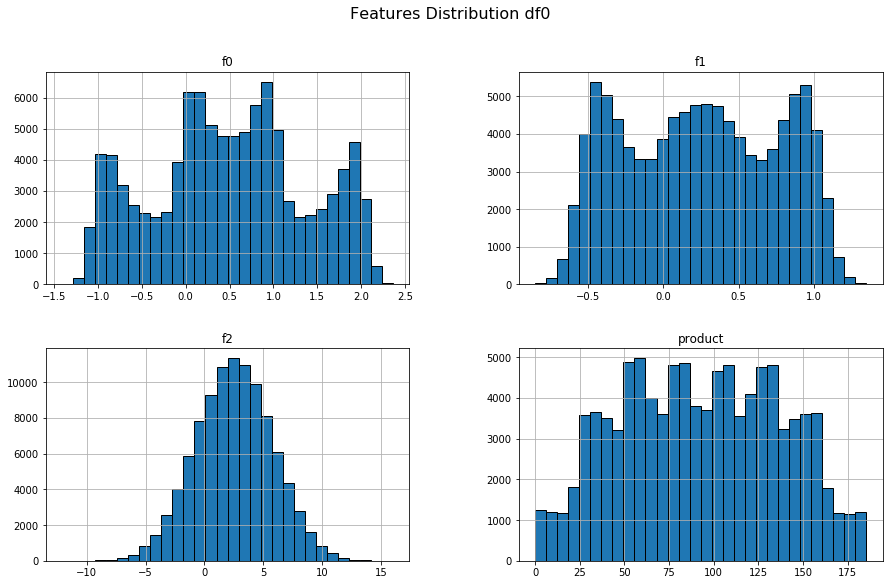

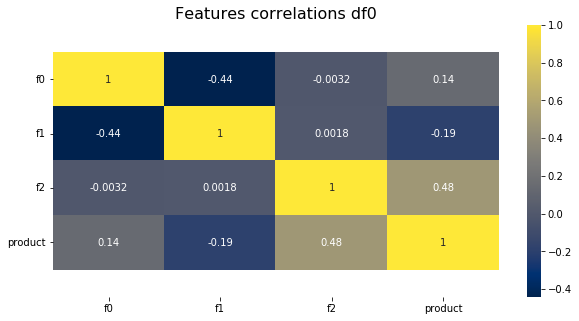

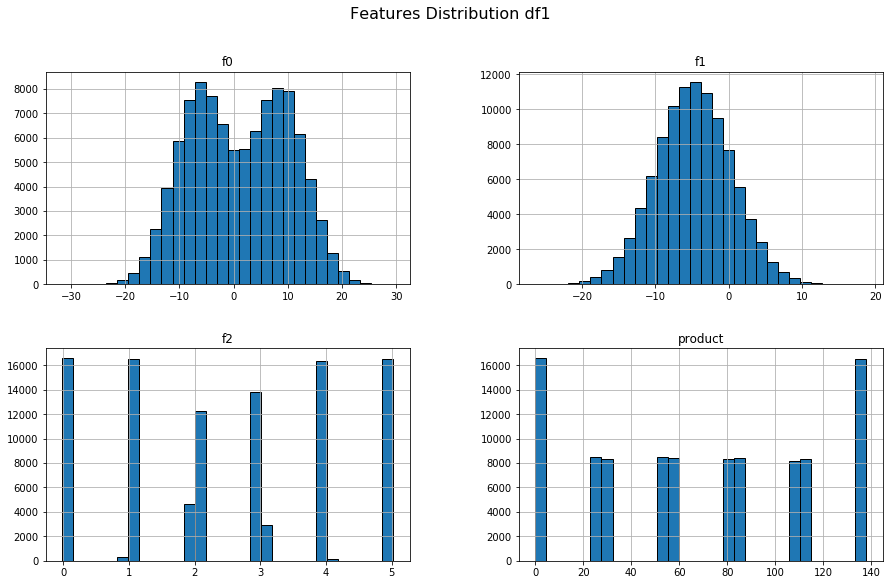

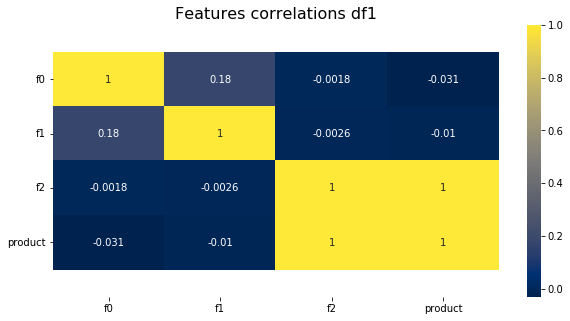

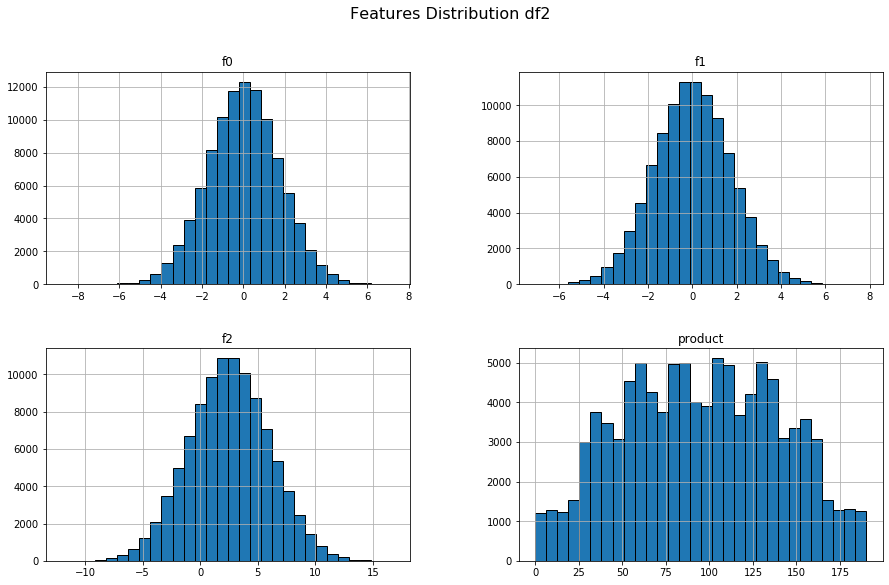

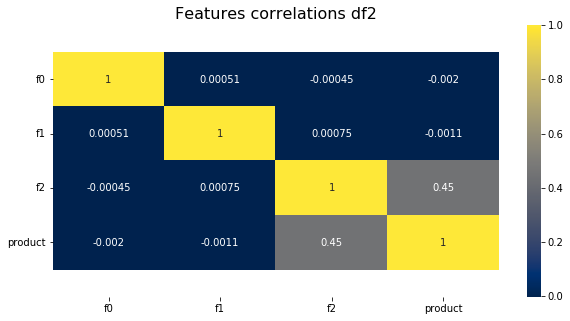

In [10]:
i = 0
for df in df_list:
    df.hist(edgecolor='black', figsize=(15,9), bins=30)
    plt.suptitle('Features Distribution df'+str(i), fontsize=16)
    plt.figure(figsize=(10,5))
    ax = sns.heatmap(df.corr(), annot=True, cmap='cividis')
    bottom, top = ax.get_ylim()
    ax.set_ylim(bottom + 0.5, top - 0.5);
    plt.yticks(rotation=0)
    plt.title('Features correlations df'+str(i), fontsize=16);
    i+=1

**Region 0:**
Feature 0 and 1 have a weak correlation with the target which might cause our model to poorly predict the target. Also these features has a strange distribution and it's mirrored around the mean.
On the other hand, feature 2 has a medium positive correlation with the target and it's normaly distributed.

**Region 1:**
Feature 0 and 1 have a weak correlation with the target which might cause our model to poorly predict the target.
On the other hand, feature 2 has a maximal positive correlation with the target, like a linear dependence, which might cause our model to predict with pretty high accuracy.

**Region 2:**
Feature 0 and 1 have a weak correlation with the target which might cause our model to poorly predict the target.
On the other hand, feature 2 has a medium positive correlation with the target. All the features are normaly distributed.

**Conclusions:**
- There are no missing values in our data.
- There are no duplicates in the data sets except very few ids which might be doubled by mistake, we removed them.
- The correlations in the datasets seems similar for region 0 and region 2, while region 1 seems to have a very strong correlation of feature 2 with the target (product).

## Model training and testing for each region
***
<a class="anchor" id="chapter2"></a>

We will split our data into 2 parts - training set and validation set , with the ratio 3:1.
In addition, we need to standardize our features as their range exceeds the range of (-1,1) and we don't want our algorithm to give more weight on a specific feature as the units might differ.
For this task we will use a linear regression model.
We'll create a function that does the same actions for each region:
1) Spliting the data  
2) Standardizing the features  
3) Creating a model  
4) Training the model  
5) Predicting on the validation set  
6) Printing the RMSE score of the model and the average volume of product predicted  
7) Saving the true target and the prdicted target of the validation set

In [11]:
#constant random_state for repeating the same results
state = 12

In [12]:
scaler = StandardScaler()

def train_n_validate_model(df, name):
    #first split each data frame to features and target
    features = df.drop(['product'], axis=1)
    target = df['product']
    #split to train and validation sets with ratio 3:1
    features_train, features_valid, target_train, target_valid = train_test_split(
        features, target, test_size=0.25, random_state=state)
    #standardize the features
    features_train = scaler.fit_transform(features_train)
    features_valid = scaler.transform(features_valid)
    
    #create a model
    model = LinearRegression()
    #train the model
    model.fit(features_train, target_train)
    #predict on the validation set
    predicted_valid = model.predict(features_valid)
    
    print('Linear Regression model for '+name+':\n'+len('Linear Regression model for '+name+':')*'-')
    #calculate RMSE
    print('RMSE:', round(mean_squared_error(target_valid, predicted_valid, squared=False), 2))

    #calculate average volume of product predicted
    print('Average volume of product predicted:', round(predicted_valid.mean(), 2),'\n')
    sub_df = pd.DataFrame({'target': target_valid, 'predicted':predicted_valid})
    return sub_df

In [13]:
sub_df0 = train_n_validate_model(df0,'region 0')
sub_df1 = train_n_validate_model(df1,'region 1')
sub_df2 = train_n_validate_model(df2,'region 2')

Linear Regression model for region 0:
-------------------------------------
RMSE: 37.8
Average volume of product predicted: 92.41 

Linear Regression model for region 1:
-------------------------------------
RMSE: 0.89
Average volume of product predicted: 68.66 

Linear Regression model for region 2:
-------------------------------------
RMSE: 40.1
Average volume of product predicted: 94.98 



It seems that region 0 and region 2 are similar in terms model quality (RMSE score) and average volume of product.
Region 1 has a very low error score which is good.
Even though regions 0 and 2 have a greater average volume then region 1, if we take into account that regions 0 and 2 have a much higher error score than it would be reasonable to say that all three models might bring similar results.

## Profit Calculation and risk evaluation
***
<a class="anchor" id="chapter3"></a>

**Preparing for profit calculation:**
We'll store all key values for calculations in separate variables and calculate the volume of reserves sufficient for developing a new well without losses. We'll also compare the obtained value with the average volume of reserves in each region.

In [14]:
#number of wells to develop
n_wells = 200

#budget for development of 200 oil wells in USD
budget200 = 100000000

#revenue from one barrel of oil
barrel_profit = 4.5

#revenue from one unit of product
product_profit = barrel_profit*1000

In [15]:
#budget for development one oil well in USD
well_budget = budget200/n_wells
#volume of reserves sufficient for developing a new well without losses
min_vol_to_profit = well_budget/product_profit

print('Minimal volume of product to start profiting:', round(min_vol_to_profit, 2),'\n')

#the average units of product of wells per region as predicted by our model.
print('Average volume of product predicted for region 0:',round(sub_df0['predicted'].mean(), 2))
print('Average volume of product predicted for region 1:',round(sub_df1['predicted'].mean(), 2))
print('Average volume of product predicted for region 2:',round(sub_df2['predicted'].mean(), 2))

Minimal volume of product to start profiting: 111.11 

Average volume of product predicted for region 0: 92.41
Average volume of product predicted for region 1: 68.66
Average volume of product predicted for region 2: 94.98


As we can see the **average product per well is not high enough to avoid losses**, but it doesn't mean that there are no profitable wells in our regions.

**Profit Function**

In [16]:
def profit_calculation(sample, n_highest, unit_profit, i, print_profit):
    #sort the rows by the highest predictions
    sorted_sample = sample.sort_values(by=['predicted'], ascending=False)
    
    #sum the target column
    target_sum = sorted_sample['target'][:n_highest].sum()
    
    #sum the predicted column
    predicted_sum = sorted_sample['predicted'][:n_highest].sum()
    
    #calculate true revenue
    revenue = target_sum * unit_profit
    
    #calculate predicted revenue
    predicted_revenue = predicted_sum * unit_profit
    
    #calculate true profit (for 200 wells)
    true_profit = revenue - budget200
    
    #calculating predicted profit.
    predicted_profit = predicted_revenue - budget200
    if print_profit:
        print('Profits for region '+str(i)+':\n'+len('Profits for region '+str(i)+':')*'-')
        print('True profit: ${} Million'.format(round(true_profit/1000000, 2)))
        print('Predicted profit: ${} Million\n'.format(round(predicted_profit/1000000, 2)))
    return true_profit, predicted_profit

In [17]:
true_profit0, predicted_profit0 = profit_calculation(sub_df0, 200, 4500, 0, True)
true_profit1, predicted_profit1 = profit_calculation(sub_df1, 200, 4500, 1, True)
true_profit2, predicted_profit2 = profit_calculation(sub_df2, 200, 4500, 2, True)

Profits for region 0:
---------------------
True profit: $32.9 Million
Predicted profit: $39.5 Million

Profits for region 1:
---------------------
True profit: $24.15 Million
Predicted profit: $24.86 Million

Profits for region 2:
---------------------
True profit: $24.1 Million
Predicted profit: $34.1 Million



For the **overall top 200 profitable wells, the highest true profit (and predicted) is for region 0.**
We see that in all regions, the predicted profit is higher than the true profit, and for region 2 this difference is pretty high.

Now for each region we'll calculate the profit, average profit and risks with the bootstrap technique (with 1,000 random samples).

In [18]:
def bootstrap_calc(sub_df, n, i):
    #generate random numbers
    rnd = np.random.RandomState(state)
    top200_profit = []
    
    #create random subsamples with size n. for each subsample pick the 200 highest predicted wells and claculate the profit
    for j in range(n):   
        subsample = sub_df.sample(500, replace=True, random_state=rnd)
        profit = profit_calculation(subsample, 200, 4500, i, False)
        top200_profit.append(profit)
    
    #convert to dataframe
    top200_dist = pd.DataFrame(top200_profit, columns = ['true', 'predicted'])
    
    #create two plots, one for the true profit distribution and one for the predicted
    fig, axes = plt.subplots(1, 2, figsize = (11,4), sharex=True)
    sns.histplot(data=top200_dist['true']/1000000, ax=axes[0])
    sns.histplot(data=top200_dist['predicted']/1000000, ax=axes[1])
    axes[0].set(xlabel='Profit ($ Million)', ylabel='Frequecy');
    axes[0].set(title='Distribution of true profit region '+str(i));
    axes[1].set(xlabel='Profit ($ Million)', ylabel='Frequecy');
    axes[1].set(title='Distribution of predicted profit region '+str(i));
    
    plt.show()
    
    #print average profit
    print('Average Profit for region '+str(i)+':\n'+len('Average Profit for region '+str(i)+':')*'-')
    print('True average profit: ${} Million'.format(round(top200_dist.mean()[0]/1000000, 2)))
    print('Predicted average profit: ${} Million\n'.format(round(top200_dist.mean()[1]/1000000, 2)))
    
    #calculate the confidence interval
    confidence_interval = st.t.interval(0.95, len(top200_dist['true'])-1, top200_dist['true'].mean(), top200_dist['true'].sem())
    print('95% Confidence Interval for region '+str(i)+':\n'+len('95% Confidence Interval for region '+str(i)+':')*'-')
    print('Lower: ${} Million'.format(round(confidence_interval[0]/1000000, 3)))
    print('Upper: ${} Million'.format(round(confidence_interval[1]/1000000, 3)))
    
    #calculate the risk of losses
    loss_risk = (top200_dist['true']<0).mean()
    print('\nRisk of Losses for region '+str(i)+': {:.2%}'.format(loss_risk))
    
    return top200_dist, confidence_interval, loss_risk

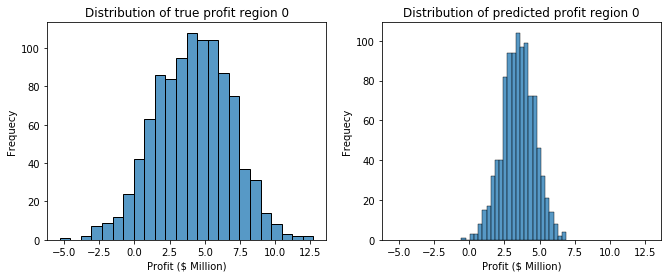

Average Profit for region 0:
----------------------------
True average profit: $4.17 Million
Predicted average profit: $3.51 Million

95% Confidence Interval for region 0:
-------------------------------------
Lower: $4.002 Million
Upper: $4.332 Million

Risk of Losses for region 0: 5.60%


In [19]:
#bootstrap technique for
top200_dist0, confidence_interval0, loss_risk0 = bootstrap_calc(sub_df0, 1000, 0)

We can see that this region has an average profit (for 200 wells) of $4.17 Millions. The model predicts the profit with a noticeable difference from the true average profit (as we mentioned before, the model predicts poorly the volume of the product, which influence how the profit is calculated).

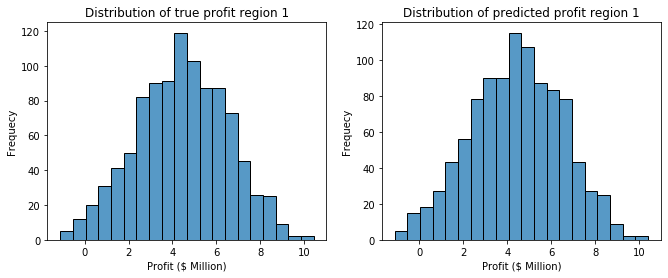

Average Profit for region 1:
----------------------------
True average profit: $4.43 Million
Predicted average profit: $4.41 Million

95% Confidence Interval for region 1:
-------------------------------------
Lower: $4.302 Million
Upper: $4.557 Million

Risk of Losses for region 1: 1.40%


In [20]:
top200_dist1, confidence_interval1, loss_risk1 = bootstrap_calc(sub_df1, 1000, 1)

We can see that this region has an average profit (for 200 wells) of $4.43 Millions, which is a bit higher than region 0. The model predicts the profit with a very good accuracy. The interval is a bit smaller than the interval of region 0. There's almost no losses (negative profits) and the risk of losses is much less than in region 0.

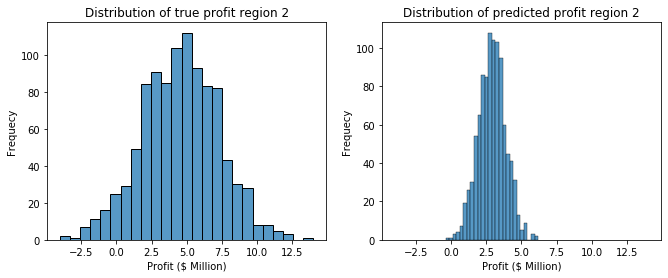

Average Profit for region 2:
----------------------------
True average profit: $4.55 Million
Predicted average profit: $2.91 Million

95% Confidence Interval for region 2:
-------------------------------------
Lower: $4.386 Million
Upper: $4.723 Million

Risk of Losses for region 2: 4.80%


In [21]:
top200_dist2, confidence_interval2, loss_risk2 = bootstrap_calc(sub_df2, 1000, 2)

We can see that this region has an average profit (for 200 wells) of $4.55 Millions which is even higher than region 1. The model predicts the profit with a noticeable difference from the true average profit (as we mentioned before, the model predicts poorly the volume of the product, which influence how the profit is calculated).
The interval in this region is the widest and as for region 0, the risk of losses is higher than region 1.

**Conclusions**:

- The highest average profit is of region 2 (\\$4.55 Millions), followed by region 1 (\\$4.43 Millions) and region 0 (\\$4.17 Millions).
- The narrowest confidence interval is of region 1.
- The lowest risk of losses is for region 1 with a noticeable sagnificance (1.4%).
- The highest risk of losses is for region 0 (5.6%).

## General conclusions
***
<a class="anchor" id="chapter4"></a>

Our company looks for the best region to invest in developing new wells so we made this study to help us choose the next location out of 3 possible. The data we collected was of good quality, though we found very few IDs that were duplicated and we need to understand why and try to avoid it.

We created 3 different linear regression models for each of the regions and tried to predict the volume of the wells in this region and the profit from them. In addition, we calculated some statistics to help with the decision. Our study shows that **the best region to invest in is region 1** as it has a high average profit, the lowest risk of losses and the narrowest confidence interval.

Regions 0 and 2 both have a too high probability of losses.